In [1]:
# kernel: wwa_xesmf
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [105,160,-10,45]
study_region = {"lon" : slice(115,135), "lat" : slice(10,30)}

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/cmip6_"

---
# Check available models
```
synda search variable=tos,ta,hus,psl -l 10000 > ~/wwa/24-08+typhoon-gaemi/cmip6-pi-vars.txt
```

Model list to use in defaults (duplicates & problematic models removed):
`source_id=CMCC-CM2-SR5,CMCC-ESM2,CNRM-CM6-1,CNRM-CM6-1-HR,CNRM-ESM2-1,CanESM5,EC-Earth3,EC-Earth3-CC,IPSL-CM6A-LR,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM`


In [ ]:
df = pd.read_table("cmip6-pi-vars.txt", sep = "\.", engine = "python", header = None,
                  names = [0,"activity","institute","source_id","experiment","variant_label","table", "variable", "grid", "version"])

In [ ]:
# identify models with all required variables available in both historical & SSP experiments
nvars = 5

mdl_xvar = df[["source_id", "variant_label", "variable", "experiment"]].drop_duplicates()
mdl_xvar = mdl_xvar.groupby(["source_id", "variant_label"]).count().reset_index()

mdl_xvar = mdl_xvar.loc[mdl_xvar.variable == (2*nvars)]

In [ ]:
mdl_xvar

In [5]:
# filter models to show only those with all four variables
df = pd.merge(df, mdl_xvar, left_on = ["source_id", "variant_label"], right_on = ["source_id", "variant_label"], how = "inner")

# get list of model variants to include in synda download
print("c+p into synda defaults file:")
"source_id="+",".join(sorted(df.source_id.drop_duplicates().to_list()))

c+p into synda defaults file:


'source_id=CESM2,CESM2-WACCM,CMCC-CM2-SR5,CMCC-ESM2,CNRM-CM6-1,CNRM-CM6-1-HR,CNRM-ESM2-1,CanESM5,EC-Earth3,EC-Earth3-CC,EC-Earth3-Veg,EC-Earth3-Veg-LR,IPSL-CM6A-LR,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM'

In [6]:
len(df.source_id.drop_duplicates())

20

In [7]:
# which variant labels provide most runs?
nmod = df.groupby(["variant_label"]).count()[["source_id"]] / (nvars*2)
nmod.sort_values("source_id")

,source_id
variant_label,
r6i1p1f2,1.3
r9i1p2f1,1.8
r2i1p2f1,1.8
r3i1p2f1,1.8
r5i1p2f1,1.8
...,...
r6i1p1f1,7.2
r4i1p1f1,10.4
r3i1p1f1,13.2


In [8]:
# list models with all available data for run r1i1p1f1 (this is the single most commonly used label)
df.loc[df.variant_label == "r1i1p1f1", ["source_id", "grid"]].drop_duplicates().sort_values("source_id")

,source_id,grid
661,CESM2-WACCM,gn
660,CESM2-WACCM,gr
2101,CMCC-CM2-SR5,gn
2111,CMCC-ESM2,gn
648,CanESM5,gn
388,EC-Earth3,gr
390,EC-Earth3,gn
348,EC-Earth3-CC,gr
350,EC-Earth3-CC,gn
282,EC-Earth3-Veg,gn


In [9]:
# count of model variants
df[["source_id", "variant_label"]].drop_duplicates().groupby(["source_id"]).count()

,variant_label
source_id,
CESM2,3
CESM2-WACCM,3
CMCC-CM2-SR5,1
CMCC-ESM2,1
CNRM-CM6-1,5
CNRM-CM6-1-HR,1
CNRM-ESM2-1,5
CanESM5,20
EC-Earth3,8


---
# List downloaded models

In [4]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/*/*/*.nc"))
df = pd.DataFrame([fnm.split("/")[-1].split("_") for fnm in fl], columns = ["variable", "frequency", "source_id", "experiment", "ensemble_id", "grid", "timeslice"])

# filter only the variables we actually need for the potential intensity
df = df.loc[[v in ["tos","hus","ta","psl"] for v in df.variable]]

df["ys"] = [int(t[:4]) for t in df.timeslice]
df["ye"] = [int(t[9:13]) for t in df.timeslice]

In [5]:
# progress
pd.crosstab(index = df.source_id, columns = df.variable)

variable,hus,psl,ta,tos
source_id,,,,
CMCC-CM2-SR5,126,11,126,26
CMCC-ESM2,126,11,126,26
CanESM5,26,2,26,26
EC-Earth3,251,251,251,251
EC-Earth3-CC,251,251,251,251
EC-Earth3-Veg,251,251,251,251
EC-Earth3-Veg-LR,251,251,251,251
IPSL-CM6A-LR,3,2,3,2
MIROC6,251,26,251,26


In [6]:
df = merge_byindex([df[["source_id", "variable", "ys"]].groupby(["source_id", "variable"]).min(),
                       df[["source_id", "variable", "ye"]].groupby(["source_id", "variable"]).max()]).reset_index()

In [7]:
# list models with data spanning the minimum period required for all four variables
mcount = df.loc[(df.ys <= 1950) & (df.ye >= 2050)].groupby(["source_id"]).count()[["variable"]]
mlist = mcount.loc[mcount.variable == 4].index.to_list()
# mlist = [m for m in mlist if not "Veg" in m]

In [8]:
mlist

['CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM']

## Extract data subset

### SSTs

In [48]:
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/tos/"

fl = sorted(glob.glob(fpath+"*/tos/*gn*.nc"))
c = 0
for fnm in fl:
    
#     if "Earth3" in fnm: continue
    
    # only print 50 filenames at a time
    c = c+1
    if c == 50:
        clear_output(wait = False)
        c = 0
        
    print(fnm.split("/")[-1])
    new_fnm = outpath + fnm.split("/")[-1]
    if os.path.exists(new_fnm): continue

    ds = xr.open_dataset(fnm)
    if "longitude" in ds.coords: ds = ds.rename({"longitude" : "lon", "latitude" : "lat"})
    if "nav_lon" in ds.coords: ds = ds.rename({"nav_lon" : "lon", "nav_lat" : "lat"})

    box = np.logical_and(np.logical_and(ds.lon >= xn, ds.lon <= xx), np.logical_and(ds.lat >= yn, ds.lat <= yx))
    
    if "i" in ds.dims:
        xdim,ydim = ["i","j"]
    else:
        xdim,ydim = ["x","y"]
    box = box.where(box == 1).dropna(xdim, "all").dropna(ydim,"all")

    ds = ds.sel({xdim : box[xdim], ydim : box[ydim]}).tos
    ds.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

In [26]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"

glob.glob(fpath+"tos-rg/*IPSL*")

['/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/tos-rg/tos-rg_Oday_IPSL-CM6A-LR_historical_r1i1p1f1_gn_18500101-20141231.nc',
 '/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/tos-rg/tos-rg_Oday_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_20150101-21001231.nc']

In [6]:
ds = xr.open_dataset('/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/IPSL-CM6A-LR/tos/tos_Oday_IPSL-CM6A-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
if "nav_lon" in ds.coords: ds = ds.rename({"nav_lon" : "lon", "nav_lat" : "lat"})
box = np.logical_and(np.logical_and(ds.lon >= xn, ds.lon <= xx), np.logical_and(ds.lat >= yn, ds.lat <= yx))
box = box.where(box == 1).dropna("x", "all").dropna("y","all")

ts = ds.sel(x = box.x, y = box.y).tos.mean(["x", "y"])

### Other variables

In [49]:
units = {"psl" : "hPa", "ta" : "degC", "hus" : "g/kg"}

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"

for mdl in mlist:
    
#     if "Earth3" in mdl: continue
        
    for varnm in ["psl", "ta", "hus"]:

        outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"+varnm+"/"
        fl = sorted(glob.glob(fpath+"*/"+varnm+"/*"+mdl+"_*.nc"))

        for fnm in fl:

            print(fnm.split("/")[-1])
            new_fnm = outpath + fnm.split("/")[-1]

            if os.path.exists(new_fnm): continue

            ds = wrap_lon(xr.open_dataset(fnm))
            if "longitude" in ds.coords: ds = ds.rename({"longitude" : "lon", "latitude" : "lat"})
            if "plev" in ds.dims: ds["plev"] = convert_units_to(ds.plev, "hPa")

            ds = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx))[varnm]
            ds = convert_units_to(ds, units[varnm])
            ds.to_netcdf(new_fnm)

        clear_output(wait = False)
print("Done.")

Done.


### Regrid tos from unstructured to structured grid

Using xesmf: https://pavics-sdi.readthedocs.io/en/latest/notebooks/regridding.html

In [50]:
import xesmf as xe

In [51]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"

fl = glob.glob(fpath+"tos/*.nc")
c = 0

# fl = [fnm for fnm in fl if "NorESM" in fnm]

for fnm in fl:

    # only print 50 filnames at a time
    c = c+1
    if c == 50:
        clear_output(wait = False)
        c = 0
        
    print(fnm.split("/")[-1])
    new_fnm = re.sub("tos", "tos-rg", fnm)
    if os.path.exists(new_fnm): continue

    # load SLP file (if there is one) to get target lat-lon grid
    tmplt_fl = glob.glob(fpath+"psl/*"+fnm.split("_")[5]+"*.nc")
    if len(tmplt_fl) == 0: continue

    tmplt = xr.open_dataset(glob.glob(fpath+"psl/*"+fnm.split("_")[5]+"*.nc")[0]).isel(time = 0).reset_coords(drop = True)

    # load SSTs, convert to degrees, add CF attributes to allow regridding
    tos = convert_units_to(xr.open_mfdataset(fnm).tos, "degC")
    
    if "i" in tos.dims:
        xdim,ydim = ["i","j"]
    else:
        xdim,ydim = ["x","y"]
        
    tos[xdim].attrs['axis'] = 'X'
    tos[ydim].attrs['axis'] = 'Y'

    # regrid SSTs to regular land-sea mask grid
    rg = xe.Regridder(tos, tmplt, "bilinear", ignore_degenerate = True)
    tos_rg = rg(tos)

    # subset region & save
    tos_rg = tos_rg.sel(lon = slice(xn,xx), lat = slice(yn,yx)).assign_attrs(units = "degC").rename("sst").astype("float32")
    tos_rg.to_netcdf(new_fnm)

clear_output(wait = False)
print("Done.")

Done.


## Compute potential intensity

_Needs different kernel so done in separate notebook_

## Daily PI & SST over study region

In [2]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/typhoon_gaemi/"

In [52]:
for fnm in glob.glob(fpath+"pi/*.nc"):
    ds = xr.open_dataset(fnm)
    ts = ds.vmax.sel(study_region).mean(["lat", "lon"])
    ts.to_netcdf(fpath+"cmip6_pi/"+fnm.split("/")[-1])

In [63]:
# compile EC-Earth files
for mpath in glob.glob(fpath+"pi/EC-Earth3*"):
    print(mpath)
    
    new_fnm = outpath+"cmip6_pi/pi_"+mpath.split("/")[-1]+".nc"
    if os.path.exists(new_fnm): continue
    
    ds = xr.concat([xr.open_dataset(fnm).vmax.sel(study_region) for fnm in sorted(glob.glob(mpath+"/*.nc"))], "time")
    ts = ds.mean(["lat", "lon"])
    ts.to_netcdf(new_fnm)

/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/pi/EC-Earth3-Veg-LR
/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/pi/EC-Earth3


In [46]:
mlist = sorted(list(set([fnm.split("_")[5] for fnm in glob.glob(fpath+"tos-rg/*.nc")])))
for mdl in mlist:
    
    print(mdl)
    new_fnm = outpath+"cmip6_sst/sst_"+mdl+".nc"
    if os.path.exists(new_fnm): continue
        
    ds = xr.concat([xr.open_dataset(fnm).sel(study_region) for fnm in sorted(glob.glob(fpath+"tos-rg/*_"+mdl+"*.nc"))], "time")
    ts = ds.sst.mean(["lat", "lon"])
    ts.to_netcdf(new_fnm)

CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM


In [44]:
# have to fix the calendar change in NESM
ts = xr.concat([ts.isel(time = slice(None, (2015-1850)*365+40)),
          convert_calendar(ts.isel(time = slice((2015-1850)*365+40, None)), "default", align_on = "date")], "time")
ts.to_netcdf(new_fnm)

## Get monthly means of all variables

In [3]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"
outpath = fpath+"monthly_vars/"

In [36]:
mlist = list(set([fnm.split("_")[5] for fnm in glob.glob(fpath+"tos-rg/*") if not "NESM" in fnm]))
for mdl in mlist:
    print(mdl, end = ": ")
    
    for varnm in ["hus", "tos-rg", "ta", "psl"]:
        
        print(varnm, end = " ")
        
        new_fnm = outpath+varnm+"-monthly_"+mdl+"_r1i1p1f1.nc"
        if os.path.exists(new_fnm): continue
        
        ds = xr.open_mfdataset(fpath+varnm+"/*"+mdl+"_*.nc")
        ds = ds.resample(time = "MS").mean()
        ds = ds.convert_calendar("standard", align_on = "year")
        ds.to_netcdf(new_fnm)
        
    print("")

CMCC-CM2-SR5: hus tos-rg ta psl 
NorESM2-LM: hus tos-rg ta psl 
EC-Earth3: hus tos-rg ta psl 
EC-Earth3-Veg-LR: hus tos-rg ta psl 
CanESM5: hus tos-rg ta psl 
EC-Earth3-CC: hus tos-rg ta psl 
EC-Earth3-Veg: hus tos-rg ta psl 
NorESM2-MM: hus tos-rg ta psl 
MPI-ESM1-2-LR: hus tos-rg ta psl 
IPSL-CM6A-LR: hus tos-rg ta psl 
MIROC6: hus tos-rg ta psl 
MPI-ESM1-2-HR: hus tos-rg ta psl 
MRI-ESM2-0: hus tos-rg ta psl 
CMCC-ESM2: hus tos-rg ta psl 


In [ ]:
for varnm in ["hus", "tos-rg", "ta", "psl"]:
    
    new_fnm = outpath+varnm+"-monthly_NESM3_r1i1p1f1.nc"
    if os.path.exists(new_fnm): continue
    
    ds_hist = xr.open_mfdataset(fpath+varnm+"/*NESM3_historical*.nc").resample(time = "MS").mean().convert_calendar("standard", align_on = "date")
    ds_ssp = xr.open_mfdataset(fpath+varnm+"/*NESM3_ssp585*.nc").resample(time = "MS").mean().convert_calendar("standard", align_on = "date")
    
    ds = xr.concat([ds_hist, ds_ssp], "time")
    ds.to_netcdf(new_fnm)
    

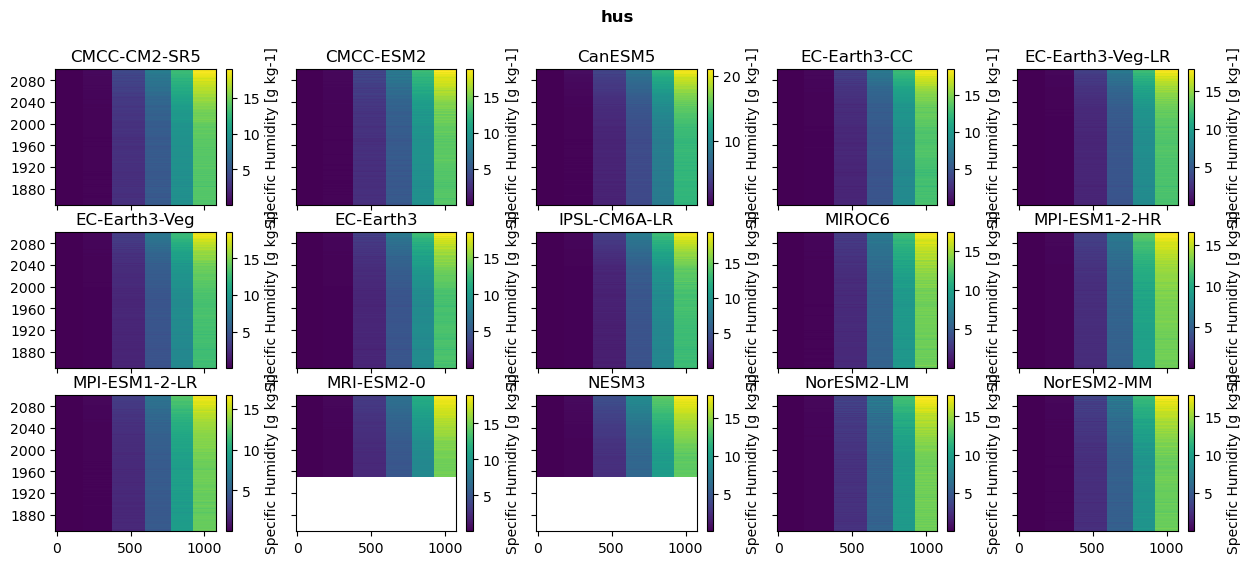

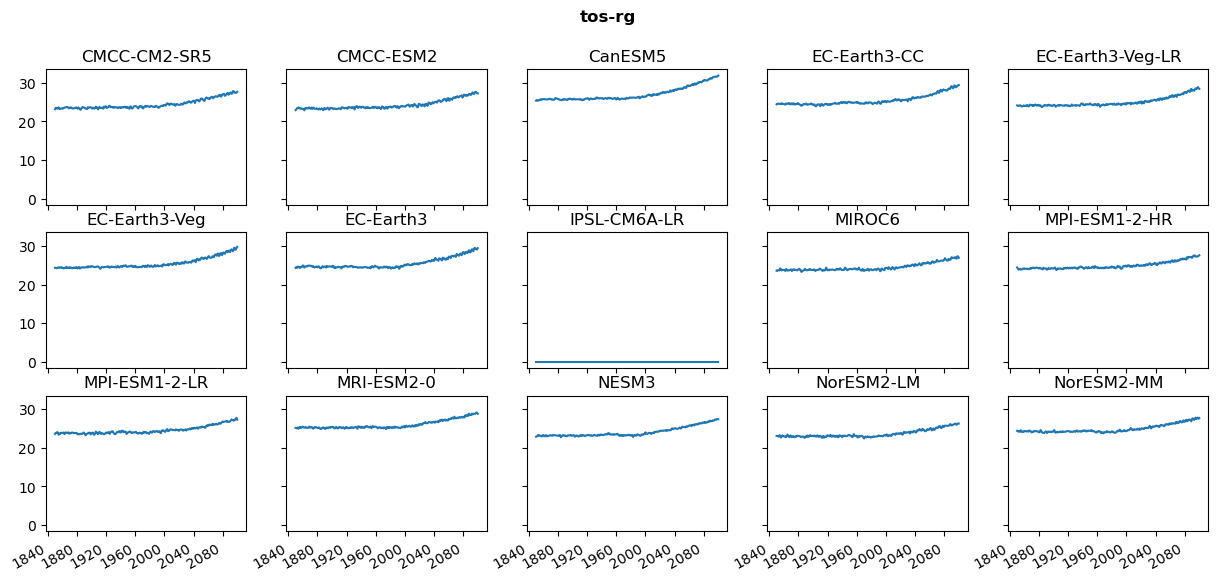

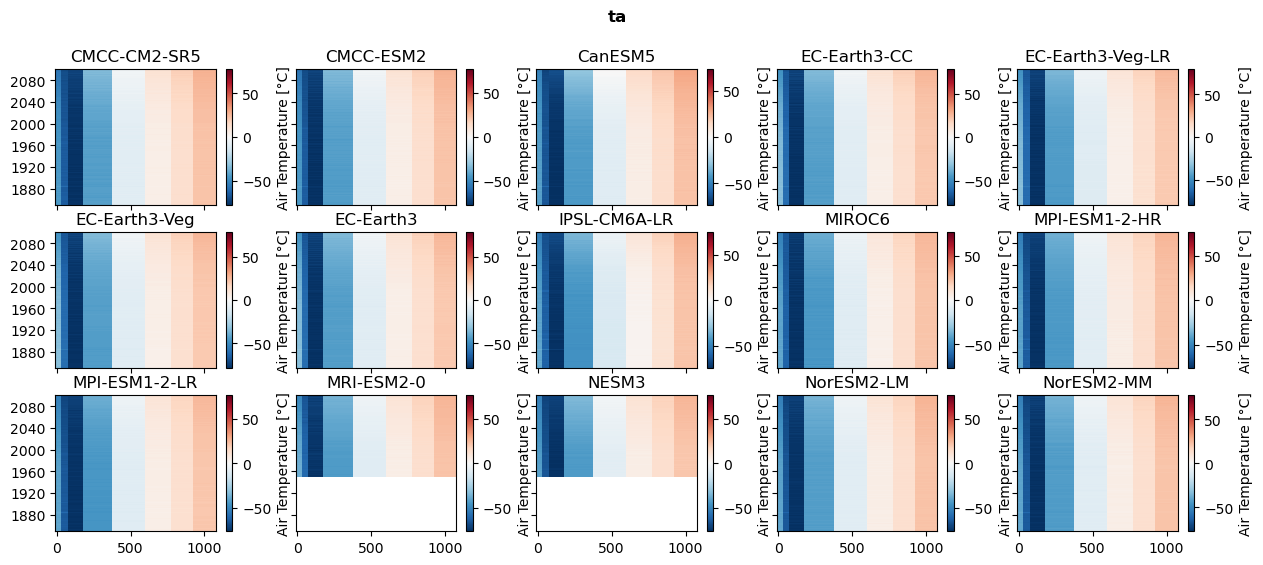

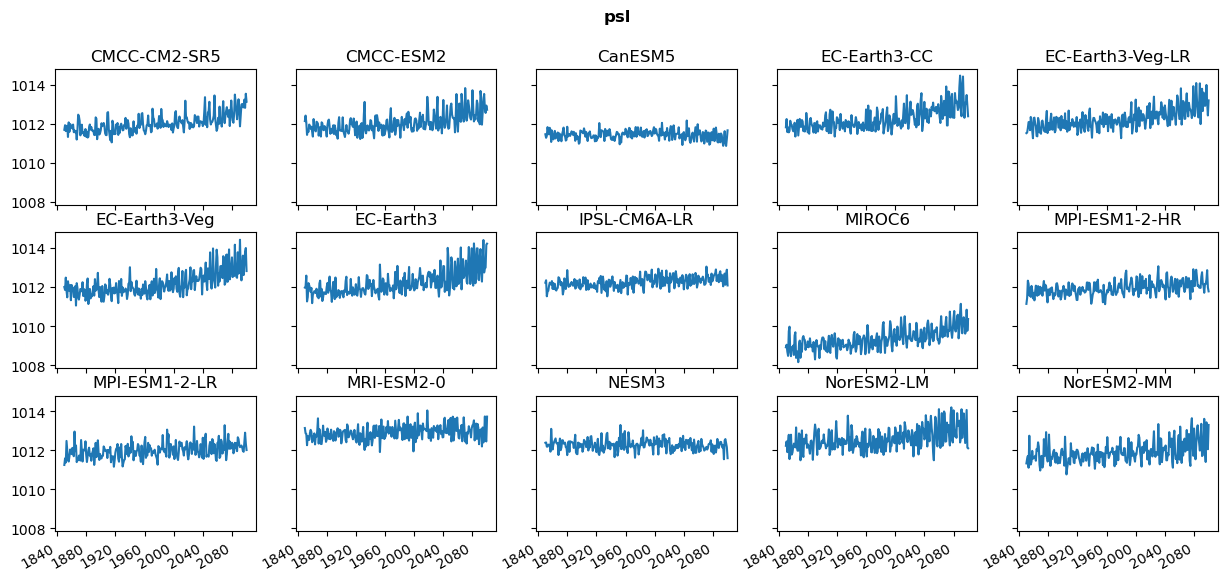

In [5]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/"
outpath = fpath+"monthly_vars/"
for varnm in ["hus", "tos-rg", "ta", "psl"]:
    fl = sorted(glob.glob(outpath+varnm+"-monthly_*_r1i1p1f1.nc"))
    
    if varnm == "tos-rg":
        vnm = "sst"
    else:
        vnm = varnm
    
    fig, axs = plt.subplots(ncols = 5, nrows = 3, figsize = (15,6), dpi = 100, sharex = True, sharey = True)
    
    for i in range(len(fl)):
        ax = fig.axes[i]
        fnm = fl[i]
        
        ts = xr.open_dataset(fnm)[vnm].mean(["lat", "lon"]).resample(time = "AS").mean()
        ts.plot(ax = ax)
        ax.set_title(fnm.split("_")[-2])
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    plt.suptitle(varnm, fontweight = "bold")
    
plt.savefig("fig/mdl-eval_cmip6_"+varnm+"-check.png")

---
# ERA5

## Resample hourly to daily data

In [64]:
fpath = "/rds/general/user/cb2714/home/99_ephemera/pi_era5/"
outpath = "data/era5_pi/"

In [65]:
fl = glob.glob(fpath+"*.nc")

In [68]:
for y in range(2023,1978,-1):
    
    print(y, end = " ")
    
    for varnm in ["sst","hus","mslp","ta"][:1]:
        print(varnm,end = " ")
        
        new_fnm = outpath+varnm+"-daily_era5_"+str(y)+".nc"
        if os.path.exists(new_fnm): continue
            
        ds = xr.open_dataset(fpath+varnm+"_era5_"+str(y)+".nc").reset_coords(drop = True)
        ds = ds.resample(valid_time = "D").mean()
        ds = ds.rename(valid_time = "time")
        if "pressure_level" in ds.dims: ds["pressure_level"] = convert_units_to(ds.pressure_level, "hPa")
        
        if varnm == "sst": ds = convert_units_to(ds.sst, "degC")
        if varnm == "hus": ds = convert_units_to(ds.q, "g/kg")
        if varnm == "ta" : ds = convert_units_to(ds.t, "degC")
        if varnm == "mslp" : ds = convert_units_to(ds.msl, "hPa")
            
        ds.to_netcdf(new_fnm)
    print("")
clear_output(wait = False)
print("Done.")

Done.


In [81]:
ds = wrap_lon(xr.open_mfdataset("data/era5_pi/sst-daily_era5_*.nc")).sst.rename(longitude = "lon", latitude = "lat").sel(study_region)
ts = convert_units_to(ds.mean(["lat", "lon"]), "degC")
ts.to_netcdf("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/typhoon_gaemi/sst_ts-daily_era5.nc")

## Get monthly data

In [42]:
ds = xr.open_mfdataset("data/era5_pi/sst-daily*.nc").resample(time = "MS").mean()
ds.to_netcdf("data/era5_pi/sst-monthly_era5.nc")

In [48]:
ds = xr.merge([xr.open_dataset("data/era5_pi/"+varnm+"-daily_era5_2024.nc") for varnm in ["hus", "ta", "sst", "mslp"]]).resample(time = "MS").mean()
ds.to_netcdf("data/era5_pi/pi-vars-monthly_era5_2024.nc")

## ERA5 from monthly variables at all pressure levels

In [86]:
ds1 = xr.open_dataset("era5_monthly_sst-psl_2023-24.nc").reset_coords(drop = True)
ds1["sp"] = convert_units_to(ds1.sp, "hPa")
ds1["msl"] = convert_units_to(ds1.msl, "hPa")
ds1["sst"] = convert_units_to(ds1.sst, "degC")

ds2 = xr.open_dataset("era5_monthly_ta-hus_2023-24.nc")[["q","t"]]
ds2["q"] = convert_units_to(ds2.q, "g/kg")
ds2["t"] = convert_units_to(ds2.t, "degC")
ds2["pressure_level"] = convert_units_to(ds2.pressure_level, "hPa")

ds = xr.merge([ds1, ds2]).rename(pressure_level = "p", latitude = "lat", longitude = "lon")
ds = ds.assign_coords(date = [pd.to_datetime(str(d), format = "%Y%m%d") for d in ds.date.values]).rename(date = "time")
ds.to_netcdf("era5_monthly_pi-vars.nc")

## JJAS maxima for trend fitting (from monthly PI)

In [139]:
ds = wrap_lon(xr.open_dataset("data/mpi_vmax_mm_halfdeg_1979-2023.nc")).vmax.rename(latitude = "lat", longitude = "lon").sel(study_region).mean(["lat", "lon"])
ds_monthly2 = xr.open_dataset("era5_monthly_vmax.nc").mean(["lat", "lon"])

ts = xr.concat([ds, ds_monthly2.sel(time = "2024").vmax_msl], "time").dropna("time", "any")
ts.to_netcdf("data/pi_ts-monthly_era5.nc")

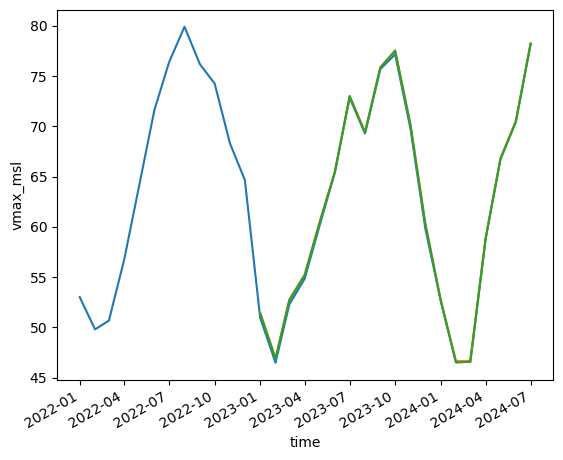

In [101]:
ts.sel(time = slice("2022",None)).plot()
ds_monthly2.vmax_sp.plot()
ds_monthly2.vmax_msl.plot()

In [140]:
ts_jjas = ts.sel(time = [m in [6,7,8,9] for m in ts.time.dt.month]).resample(time = "AS").max()
ts_jjas.assign_coords(time = ts_jjas.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_pi-jjas_monthly.csv")
ts_jjas.plot()

In [103]:
ts_sst = wrap_lon(xr.open_dataset("data/era5_pi/sst-monthly_era5.nc")).sst.rename(longitude = "lon", latitude = "lat").sel(study_region).mean(["lat", "lon"])

In [104]:
sst_jjas = ts_sst.sel(time = [m in [6,7,8,9] for m in ts_sst.time.dt.month]).resample(time = "AS").max().rename("sst")
sst_jjas.assign_coords(time = sst_jjas.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/era5_sst-jjas_monthly.csv")

---
# Nino3.4 for CMIP6

### Nino3.4 from unstructured tos

In [2]:
import xesmf as xe
import warnings; warnings.filterwarnings("ignore", message = ".+CONTIGUOUS.+")

In [3]:
# define required regions
nino34_region = {"lon" : slice(-170,-120), "lat" : slice(-5,5)}
tropics = {"lat" : slice(-20,20)}

In [4]:
# load a relatively high-res template to regrid onto
tmplt = xr.open_dataset("~/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/EC-Earth3-Veg/hurs/hurs_day_EC-Earth3-Veg_historical_r1i1p1f1_gr_18500101-18501231.nc")
tmplt = wrap_lon(tmplt.hurs.isel(time = 0).reset_coords(drop = True).sel(tropics))

In [5]:
fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/nino34/"

In [6]:
# mlist = list(set([fnm.split("_")[6] for fnm in sorted(glob.glob(fpath+"*/tos/*gn*.nc"))]))
# mlist = ['CMCC-CM2-SR5', 'CMCC-ESM2', 'CanESM5', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'NorESM2-MM']
mlist = ['NESM3', 'EC-Earth3-CC', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg']

In [7]:
for mdl in mlist:
    
    print(mdl, end = "")
    
    fl = sorted(glob.glob(fpath+mdl+"/tos/*"))
    if len(glob.glob(outpath+"*"+mdl+"*.nc")) == len(fl): 
        print("")
        continue
    
    # open first dataset to build regridder
    ds = xr.open_dataset(fl[0])
    if "longitude" in ds.coords: ds = ds.rename({"longitude" : "lon", "latitude" : "lat"})
    if "nav_lon" in ds.coords: ds = ds.rename({"nav_lon" : "lon", "nav_lat" : "lat"})
    
    if "i" in ds.dims:
        xdim,ydim = ["i","j"]
    else:
        xdim,ydim = ["x","y"]
    
    ds[xdim].attrs['axis'] = 'X'
    ds[ydim].attrs['axis'] = 'Y'
    
    rg = xe.Regridder(ds, tmplt, "bilinear", ignore_degenerate = True)
    print(":", end = "")
    
    # apply regridder to each file in turn
    for fnm in fl:
        new_fnm = outpath + re.sub("tos", "nino34det",fnm.split("/")[-1])
        if os.path.exists(new_fnm): continue
            
        da = xr.open_dataset(fnm).tos
        tos_rg = rg(da).resample(time = "MS").mean()
    
        # subset regions, detrend tos & save
        tos_tropical = tos_rg.mean(["lat", "lon"])
        tos_nino34 = tos_rg.sel(nino34_region).mean(["lat", "lon"])

        nino = (tos_nino34 - tos_tropical).rename("nino34_det").assign_attrs(units = "degC")
        nino.to_netcdf(new_fnm)
        print(".", end = "")
        
    print("")
    
clear_output(wait = False)
print("Done.")

Done.


In [8]:
# compile into one file per model
mlist = list(set([fnm.split("_")[5]+"_*_"+fnm.split("_")[7] for fnm in glob.glob(outpath+"/*.nc") if not "NESM" in fnm]))
for mdl in mlist:
    ds = xr.open_mfdataset(outpath+"/*"+mdl+"*.nc")
    ds.to_netcdf("data/nino34/nino34-det_"+re.sub("_\*", "", mdl)+".nc")

In [9]:
# DJF time series for use as covariates - will use DJF before the monsoon season, so label at end of season (ie. DJF 2023-2024 affects July 2024 cyclones)
for fnm in glob.glob("data/nino34/nino34-det_*.nc"):
    
    new_fnm = "ts/cmip6_nino34det_"+"_".join(fnm[:-3].split("_")[-2:])+".csv"
    if os.path.exists(new_fnm): continue
    
    ds = xr.open_dataset(fnm).nino34_det
    nino_djf = ds.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"]
    
    full_seasons = ds.resample(time = "MS").count().resample(time = "QS-DEC").sum().groupby("time.season")["DJF"] == 3
    nino_djf = nino_djf.where(full_seasons).dropna("time", "any")
    
    nino_djf = nino_djf.assign_coords(time = nino_djf.time.dt.year + 1).rename(time = "year")
    nino_djf.to_dataframe().to_csv(new_fnm)

# Time series for climate explorer

In [10]:
outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/typhoon_gaemi/ts/"

In [142]:
ts = pd.read_csv("ts/era5_pi-jjas_monthly.csv", index_col = "year")

csv_fnm = "typhoon-gaemi_pi_era5"
        
csv_fullpath = outpath+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 - JJAS max of monthly maximum potential intensity over study region - Typhoon Gaemi 2024, c.barnes22@imperial.ac.uk"
str2 = "# pi [m/s] potential intensity calculated from monthly data using tcpypi over 115E-135E, 10N-30N at "+csv_fnm+".dat"
head = "# year pi"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

In [146]:
ts = pd.read_csv("ts/era5_sst-jjas_monthly.csv", index_col = "year")

csv_fnm = "typhoon-gaemi_sst_era5"
        
csv_fullpath = outpath+csv_fnm+".dat"
if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

# create extra header lines for upload to Climate Explorer 
str1 = "# contact :: ERA5 - JJAS max of monthly maximum potential intensity over study region - Typhoon Gaemi 2024, c.barnes22@imperial.ac.uk"
str2 = "# pi [m/s] potential intensity calculated from monthly data using tcpypi over 115E-135E, 10N-30N at "+csv_fnm+".dat"
head = "# year pi"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

clear_output(wait = False)

In [145]:
for fnm in glob.glob("ts/cmip6_pi_*.csv"):
    
    mdl = fnm[:-4].split("_")[-1]+"_r1i1p1f1"
    ts = pd.read_csv(fnm, index_col = "year")["jjas_m"]
    
    csv_fnm = "typhoon-gaemi_pi_cmip6_"+mdl
        
    csv_fullpath = outpath+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" - JJAS max of monthly maximum potential intensity over study region - Typhoon Gaemi 2024, c.barnes22@imperial.ac.uk"
    str2 = "# pi [m/s] potential intensity calculated from daily data using tcpypi over 115E-135E, 10N-30N at "+csv_fnm+".dat"
    head = "# year pi"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

In [125]:
for fnm in glob.glob("ts/cmip6_sst_*.csv"):
    
    mdl = fnm[:-4].split("_")[-1]+"_r1i1p1f1"
    ts = pd.read_csv(fnm, index_col = "year")["jjas_m"]
    
    csv_fnm = "typhoon-gaemi_sst_cmip6_"+mdl
        
    csv_fullpath = outpath+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" - JJAS max of monthly mean of sea surface temperatures over study region - Typhoon Gaemi 2024, c.barnes22@imperial.ac.uk"
    str2 = "# sst [degC] sea surface temperatures over 115E-135E, 10N-30N at "+csv_fnm+".dat"
    head = "# year sst"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

In [11]:
for fnm in glob.glob("ts/cmip6_nino34*.csv"):
    
    mdl = fnm[:-4][19:]
    ts = pd.read_csv(fnm, index_col = "year")
 
    csv_fnm = "typhoon-gaemi_nino34_cmip6_"+mdl
        
    csv_fullpath = outpath+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact ::CMIP6 "+mdl+" - DJF mean of detrended Nino3.4 index (2024 denotes 2023-24) - Pantanal wildfires 2024, c.barnes22@imperial.ac.uk"
    str2 = "# nino [degC] December-February mean of Nino3.4 detrended by subtracting mean of tropical SSTs at "+csv_fnm+".dat"
    head = "# year nino"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)

In [ ]:
for fnm in glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/potential-intensity/monthly_vars/mpi*.nc"):
    
    mdl = "_".join(fnm[:-4].split("_")[-2:])
    
    ts = xr.open_dataset(fnm).vmax.sel(study_region).mean(["lat", "lon"])
    ts_jjas = ts.sel(time = [m in [6,7,8,9] for m in ts.time.dt.month]).resample(time = "AS").max()
    
    ts_jjas = ts_jjas.assign_coords(time = ts_jjas.time.dt.year).rename("mpi", time = "year").to_dataframe()
    
    csv_fnm = "typhoon-gaemi_mpi_cmip6_"+mdl

    csv_fullpath = outpath+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CMIP6 "+mdl+" - max of monthly maximum potential intensity over study region - Typhoon Gaemi 2024, c.barnes22@imperial.ac.uk"
    str2 = "# mpi [m/s] potential intensity calculated from monthly data using tcpypi over 115E-135E, 10N-30N at "+csv_fnm+".dat"
    head = "# year mpi"
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts_jjas.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

    clear_output(wait = False)